# Análisis Exploratorio de Datos de Imágenes y Máscaras de Segmentación

**Autora:** Julia García Vega

**Fecha:** 02/07/2024

**Descripción:** Análisis Exploratorio del conjunto de Imágenes y Máscaras de Segmentación utilizado en el Trabajo de Fin de Grado para el entrenamiento de los distintos modelos de segmentación.


## Configuración inicial

In [1]:
# para cargar los datos
import os

# para leer y procesar imágenes
import imageio
from PIL import Image

# para trabajar con arrays
import numpy as np

# para visualizaciones de imágenes y gráficos
import matplotlib.pyplot as plt

# para la generación de números aleatorios
import random

# para la importación del conjunto de datos
!pip install roboflow
from roboflow import Roboflow

# para el análisis descriptivo de los datos
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler

In [2]:
CLASSES_NAMES = ['fondo', 'acera', 'baldosa podotáctil', 'banco', 'carretera', 'pared', 'paso de cebra', 'vegetación']
BACKGROUND = [255,255,255]
SIDEWALK = [155, 155, 155]
PODOTACTILE_PAVEMENT = [255, 89, 94]
BENCH = [255, 146, 76]
ROAD = [28, 48, 74]
WALL = [255, 202, 58]
CROSSWALK = [25, 130, 196]
VEGETATION = [138, 201, 38]
COLOR_DICT = np.array([BACKGROUND, SIDEWALK, PODOTACTILE_PAVEMENT, BENCH, ROAD, WALL, CROSSWALK, VEGETATION])
TARGET_SHAPE_IMG = [128, 128, 3]
TARGET_SHAPE_MASK = [128, 128, 1]
BATCH_SIZE = 32
NUM_CLASSES = 8
TRAIN_DIR = '/content/Elementos-acera-2-12/train/'
VALID_DIR = '/content/Elementos-acera-2-12/valid/'
TEST_DIR = '/content/Elementos-acera-2-12/test/'

In [3]:
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = COLOR_DICT
    if np.max(label) > len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## Importación de los datos

Se procede a descargar el conjunto de datos del proyecto personal de Roboflow en el que se ha llevado acabo la anotación de las imágenes. Está compuesto por 5217 y se distinguen la siguientes clases:

*   0: Fondo
*   1: Acera
*   2: Baldosas podotáctiles
*   3: Banco
*   4: Carretera
*   5: Pared (Originalmente valor 7)
*   6: Paso de cebra (Originalmente valor 8)
*   7: Vegetación (Originalmente valor 9)





In [4]:
rf = Roboflow(api_key="BMCyY6qMBZoJ298pLB9G")
project = rf.workspace("tfg-nrlv7").project("elementos-acera-2")
dataset = project.version(12).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Elementos-acera-2-12 in png-mask-semantic:: 100%|██████████| 11926/11926 [00:04<00:00, 2537.19it/s]


In [5]:
def LoadData (path):
    """
    Carga los datos devolviendo dos listas, una con los nombres de los ficheros
    de imágenes y otra con los nombres de los ficheros de las máscaras
    """
    #Obtener un listado de los archivos en esa ubicación
    dataset = os.listdir(path)

    #Filtrar respectivamente las imágenes (archivos .jpg) y las máscaras (archivos .png)
    image_dataset = [file_name for file_name in dataset if file_name.endswith('.jpg')]
    mask_dataset = [file_name for file_name in dataset if file_name.endswith('.png')]

    # Ordenar ambas listas para que tengan en el mismo índice la imagen y máscara correspondiente
    image_dataset.sort()
    mask_dataset.sort()

    return image_dataset, mask_dataset

train_image_dataset, train_mask_dataset = LoadData(TRAIN_DIR)
valid_image_dataset, valid_mask_dataset = LoadData(VALID_DIR)
test_image_dataset, test_mask_dataset = LoadData(TEST_DIR)

In [6]:
NUM_TRAIN_IMAGES = len(train_mask_dataset)
NUM_VALID_IMAGES = len(valid_mask_dataset)
NUM_TEST_IMAGES = len(test_mask_dataset)

print("Número imágenes entrenamiento: ", NUM_TRAIN_IMAGES)
print("Número imágenes validación: ", NUM_VALID_IMAGES)
print("Número imágenes test: ", NUM_TEST_IMAGES)

Número imágenes entrenamiento:  5217
Número imágenes validación:  495
Número imágenes test:  247


Inicialmente, debido a que se consideraron dos clases adicionales (escaleras de subida y escaleras de bajada), al eliminarlas y extraer el conjunto de datos de Roboflow los valores enteros correspondientes con cada clase quedaron descuadrados siendo asignadas por Roboflow de la siguiente manera [0, 1, 2, 3, 4, 7, 8, 9] como se puede observar a continuación. Por ello, se procede a corregir este hueco en la secuencia sustituyendo la clase 7 por la clase 5, la clase 8 por la clase 6 y la clase 9 por la clase 7.

In [7]:
def testUniqueValues(path, mask_dataset):
    """
    Comprueba los valores únicos existentes en las máscaras
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en el conjunto de imágenes:")
    print(unique_total_values)

def adjustUniqueValues(path, mask_dataset):
    """
    Ajusta los valores únicos existentes en las máscaras para corregir la falta de clases
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Reemplazar los valores 7, 8 y 9 por 5, 6 y 7 respectivamente
        image = np.where(image == 7, 5, image)
        image = np.where(image == 8, 6, image)
        image = np.where(image == 9, 7, image)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

        # Guardar la imagen modificada en la misma ubicación con el mismo nombre
        imageio.imwrite(image_path, image)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en el conjunto de imágenes:")
    print(unique_total_values)

In [8]:
testUniqueValues(TRAIN_DIR, train_mask_dataset)
testUniqueValues(VALID_DIR, valid_mask_dataset)
testUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]


In [9]:
adjustUniqueValues(TRAIN_DIR, train_mask_dataset)
adjustUniqueValues(VALID_DIR, valid_mask_dataset)
adjustUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]


## Visualización de imágenes y su máscara correspondiente

Se muestra primero la correspondencia entre los colores, los números de clase y los nombres de clase. :

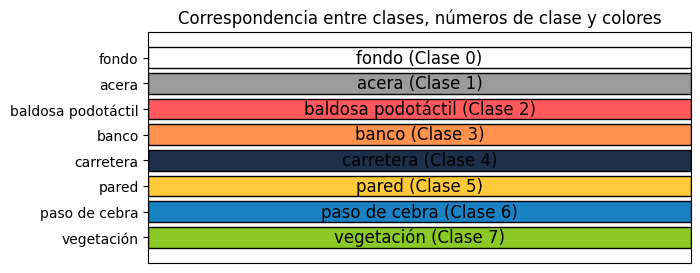

In [35]:
fig, ax = plt.subplots(figsize=(7, 3))
for i, (name, color) in enumerate(zip(CLASSES_NAMES, COLOR_DICT)):
    ax.barh(i, 1, color=np.array(color) / 255, edgecolor='black')
    ax.text(0.5, i, f'{name} (Clase {i})', va='center', ha='center', color='black', fontsize=12)

# Configurar el gráfico
ax.set_yticks(range(len(CLASSES_NAMES)))
ax.set_yticklabels(CLASSES_NAMES)
ax.set_xticks([])
ax.set_xlim(0, 1)
ax.set_ylim(-1, len(CLASSES_NAMES))
ax.set_title('Correspondencia entre clases, números de clase y colores')
ax.invert_yaxis()

plt.show()


A continuación, se procede con una visualización inicial de algunas imágenes y su máscara correspondiente. Esto permite verificar visualmente la correcta correspondencia entre imágenes y sus máscaras.

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)


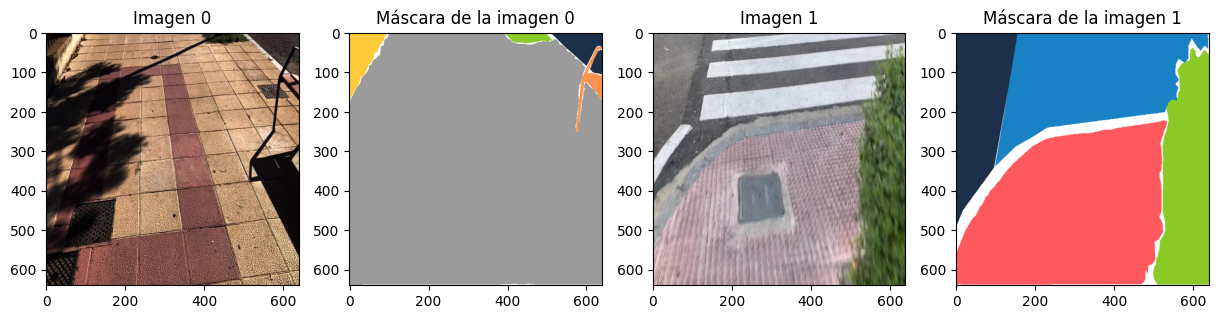

In [60]:
show_images = 2
num_rows = (show_images + 1) // 2

random_ints = np.random.randint(0, NUM_TRAIN_IMAGES - 1, size=show_images)
for index, num in enumerate(random_ints):
    img_view  = imageio.imread(TRAIN_DIR + train_image_dataset[num])
    mask_view = imageio.imread(TRAIN_DIR + train_mask_dataset[num])
    mask_view_color = label_to_color_image(mask_view).astype(np.uint8)
    if index == 0:
      print("Dimensión imágen: ", img_view.shape)
      print("Dimensión máscara: ", mask_view.shape)

    temp = index % 2
    if temp == 0:
      fig, axes = plt.subplots(1, 4, figsize=(15, 15))
      col_index = 0
    else:
      col_index = 2

    axes[col_index].imshow(img_view)
    axes[col_index].set_title('Imagen '+ str(index))
    axes[col_index+1].imshow(mask_view_color)
    axes[col_index+1].set_title('Máscara de la imagen '+ str(index))
    if col_index == 2:
        plt.show()
    elif index == show_images - 1:
        fig.delaxes(axes[2])
        fig.delaxes(axes[3])

## Preprocesamiento del conjunto de datos



In [12]:
def PreprocessData(image_dataset, mask_dataset, target_shape_img, target_shape_mask, path):
    """
    Preprocesa las imágenes y mascaras presentes en las listas y la ubicación
    pasada como argumento.
    Devuelve dos arrays de cuatro dimensiones que contienen las imágenes y máscaras
    como arrays. Las dimensiones corresponden con lo siguiente:
        Primera dimensión:              número de imágenes/máscaras
        Segunda y tercera dimensión:    ancho y alto deseado
        Cuarta dimensión:               número de canales.
                                            las imágenes 3 canales (RGB)
                                            las máscaras 1 canal (escala de grises)
    """
    # Extraer las dimensiones relevantes
    num_images = len(image_dataset)  # número de imágenes
    i_h,i_w,i_c = target_shape_img   # altura, ancho y canales de una imagen
    m_h,m_w,m_c = target_shape_mask  # altura, ancho y canales de una máscara

    # Definir X e Y como el número de imágenes junto con la dimensión de una imagen
    X = np.zeros((num_images,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((num_images,m_h,m_w,m_c), dtype=np.int32)

    # Redimensionar imágenes y máscaras
    for i in range(num_images):
        # convertir la imagen en un array con la forma deseada
        image_name = image_dataset[i]
        image_path = os.path.join(path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((i_h,i_w))
        image = np.reshape(image,(i_h,i_w,i_c))
        image = image/255.
        X[i] = image

        # convertir la máscara en un array con la forma deseada
        mask_name = mask_dataset[i]
        mask_path = os.path.join(path, mask_name)
        mask = Image.open(mask_path)
        mask = mask.resize((m_h, m_w),Image.NEAREST) #Con flag Image.NEAREST para que no se cree una nueva clase por la interpolación de los píxeles
        mask = np.reshape(mask,(m_h,m_w,m_c))

        y[i] = mask

    return X, y

In [13]:
X_train, y_train = PreprocessData(train_image_dataset, train_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TRAIN_DIR)
X_valid, y_valid = PreprocessData(valid_image_dataset, valid_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, VALID_DIR)
X_test, y_test = PreprocessData(test_image_dataset, test_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TEST_DIR)

Se combinan los tres grupos de datos para realizarse el análisis exploratorio sobre el conjunto total.

In [14]:
X = np.concatenate([X_train, X_valid, X_test], axis=0)
y = np.concatenate([y_train, y_valid, y_test], axis=0)

Se presentan a continuación las imágenes y sus máscaras visualizadas anteriormente pero ahora procesadas para mostrar el cambio aplicado.

Dimensión imágen:  (128, 128, 3)
Dimensión máscara:  (128, 128, 1)


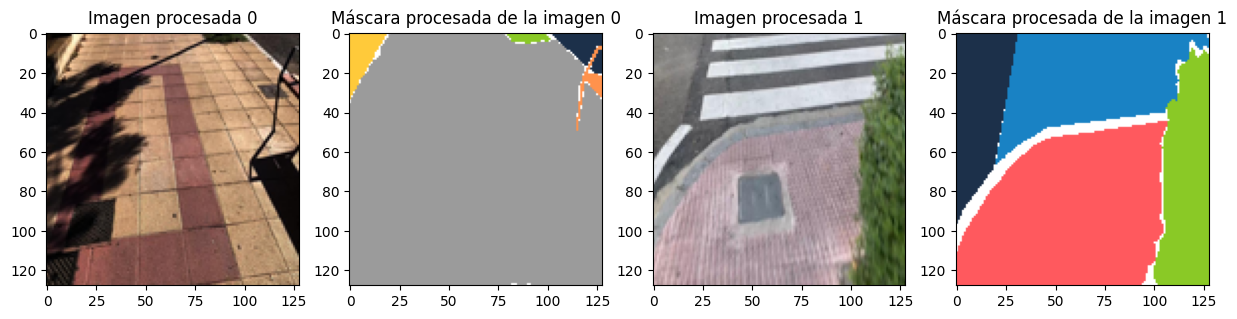

In [62]:
for index, num in enumerate(random_ints):
    if index == 0:
      print("Dimensión imágen: ", X_train[num].shape)
      print("Dimensión máscara: ", y_train[num].shape)

    temp = index % 2
    if temp == 0:
      fig, axes = plt.subplots(1, 4, figsize=(15, 15))
      col_index = 0
    else:
      col_index = 2

    axes[col_index].imshow(X_train[num])
    axes[col_index].set_title('Imagen procesada '+ str(index))
    mask_view_color = label_to_color_image(y_train[num,:,:,0]).astype(np.uint8)
    axes[col_index+1].imshow(mask_view_color)
    axes[col_index+1].set_title('Máscara procesada de la imagen '+ str(index))
    if col_index == 2:
        plt.show()
    elif index == show_images - 1:
        fig.delaxes(axes[2])
        fig.delaxes(axes[3])

## Estadísticas Básicas de las Clases

In [16]:
class_areas = {name: [] for name in CLASSES_NAMES}

for mask in y:
    for i, name in enumerate(CLASSES_NAMES):
        count = np.sum(mask == i)
        class_areas[name].append(count)

# Convertir a DataFrame para análisis más sencillo
df = pd.DataFrame(class_areas)

# Calcular estadísticas
stats = df.describe()
print(stats)

              fondo         acera  baldosa podotáctil        banco  \
count   5959.000000   5959.000000         5959.000000  5959.000000   
mean     495.874811   9679.703642          929.252391   119.957879   
std      994.940642   5153.078819         2405.288518   550.715271   
min        0.000000      0.000000            0.000000     0.000000   
25%       81.000000   7056.000000            0.000000     0.000000   
50%      157.000000  10725.000000            0.000000     0.000000   
75%      435.000000  14107.000000            0.000000     0.000000   
max    16384.000000  16384.000000        15805.000000  9780.000000   

          carretera         pared  paso de cebra    vegetación  
count   5959.000000   5959.000000    5959.000000   5959.000000  
mean    1369.127370   1419.397550    1861.799127    508.887229  
std     1937.525128   1885.720217    4395.614518   1270.450982  
min        0.000000      0.000000       0.000000      0.000000  
25%        0.000000      0.000000       0.00

## Análisis de Proporción y Distribución de Píxeles por Clase

Se calculan primero los datos necesarios para realizar los gráficos

In [17]:
class_total_counts = np.zeros(8)  # Hay 8 clases (0 a 7)
class_images_counts = [[] for _ in range(8)]
image_number_per_class = np.zeros(8)
for mask in y:
    for i in range(8):
        class_pixels = np.sum(mask == i)
        if class_pixels != 0 :
            class_images_counts[i].append(class_pixels)
            image_number_per_class[i]=image_number_per_class[i]+1
        class_total_counts[i] = class_total_counts[i] + class_pixels

class_mean = [(sum(images_counts) / len(images_counts)) *100 /(y.shape[1]*y.shape[2]) if images_counts else 0 for images_counts in class_images_counts]

Se proceden a mostrar los distintos gráficos para analizar el conjunto de datos

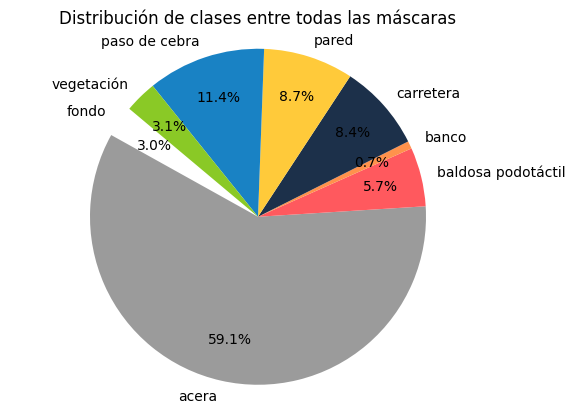

In [31]:
plt.pie(class_total_counts, colors=COLOR_DICT/255., labels=CLASSES_NAMES, startangle=140, autopct='%1.1f%%', pctdistance=0.75,)
plt.axis('equal')
plt.title('Distribución de clases entre todas las máscaras')
plt.show()

In [19]:
class_imbalance_ratio = np.max(class_total_counts) / np.min(class_total_counts)
print(f'Proporción entre la clase mayoritaria y la clase minoritaria: {class_imbalance_ratio:.2f}')

Proporción entre la clase mayoritaria y la clase minoritaria: 80.69


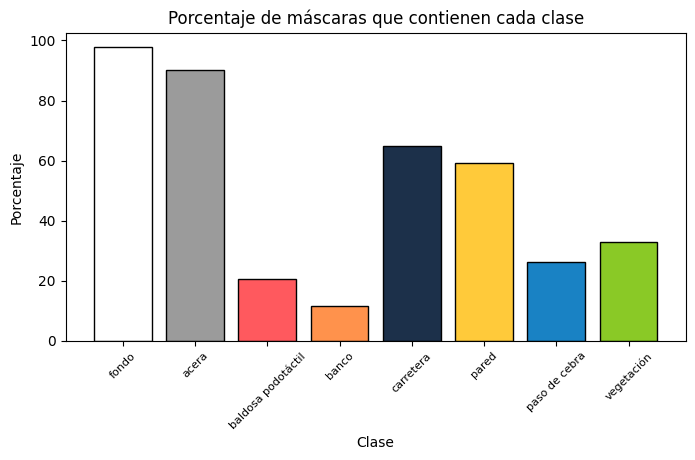

In [75]:
plt.figure(figsize=(8, 4))
plt.bar(range(8), image_number_per_class*100/y.shape[0], color=COLOR_DICT/255., edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.xticks(range(len(CLASSES_NAMES)), CLASSES_NAMES, rotation=45, fontsize=8)
plt.title('Porcentaje de máscaras que contienen cada clase')
plt.show()


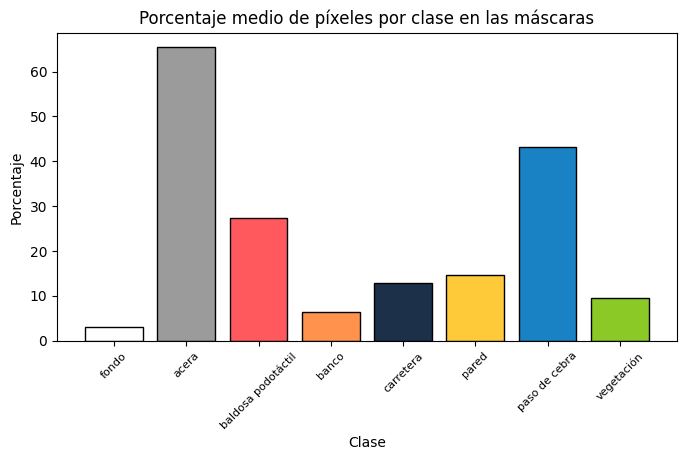

In [77]:
plt.figure(figsize=(8, 4))
plt.bar(range(8), class_mean, color=COLOR_DICT/255., edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.xticks(range(len(CLASSES_NAMES)), CLASSES_NAMES, rotation=45, fontsize=8)
plt.title('Porcentaje medio de píxeles por clase en las máscaras')
plt.show()

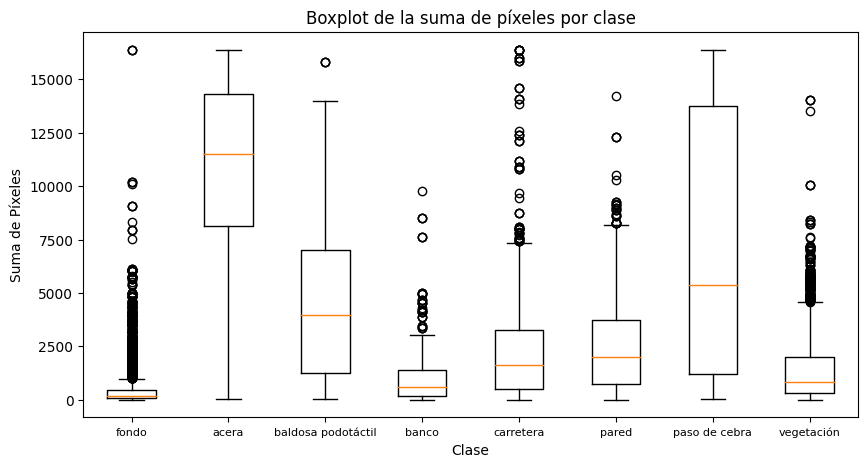

In [79]:
plt.figure(figsize=(10, 5))
plt.boxplot(class_images_counts, labels=[f'Clase {i}' for i in range(len(class_images_counts))])
plt.title('Boxplot de la suma de píxeles por clase')
plt.xlabel('Clase')
plt.ylabel('Suma de Píxeles')
plt.xticks(range(1, len(CLASSES_NAMES)+1), CLASSES_NAMES, fontsize=8)
plt.show()

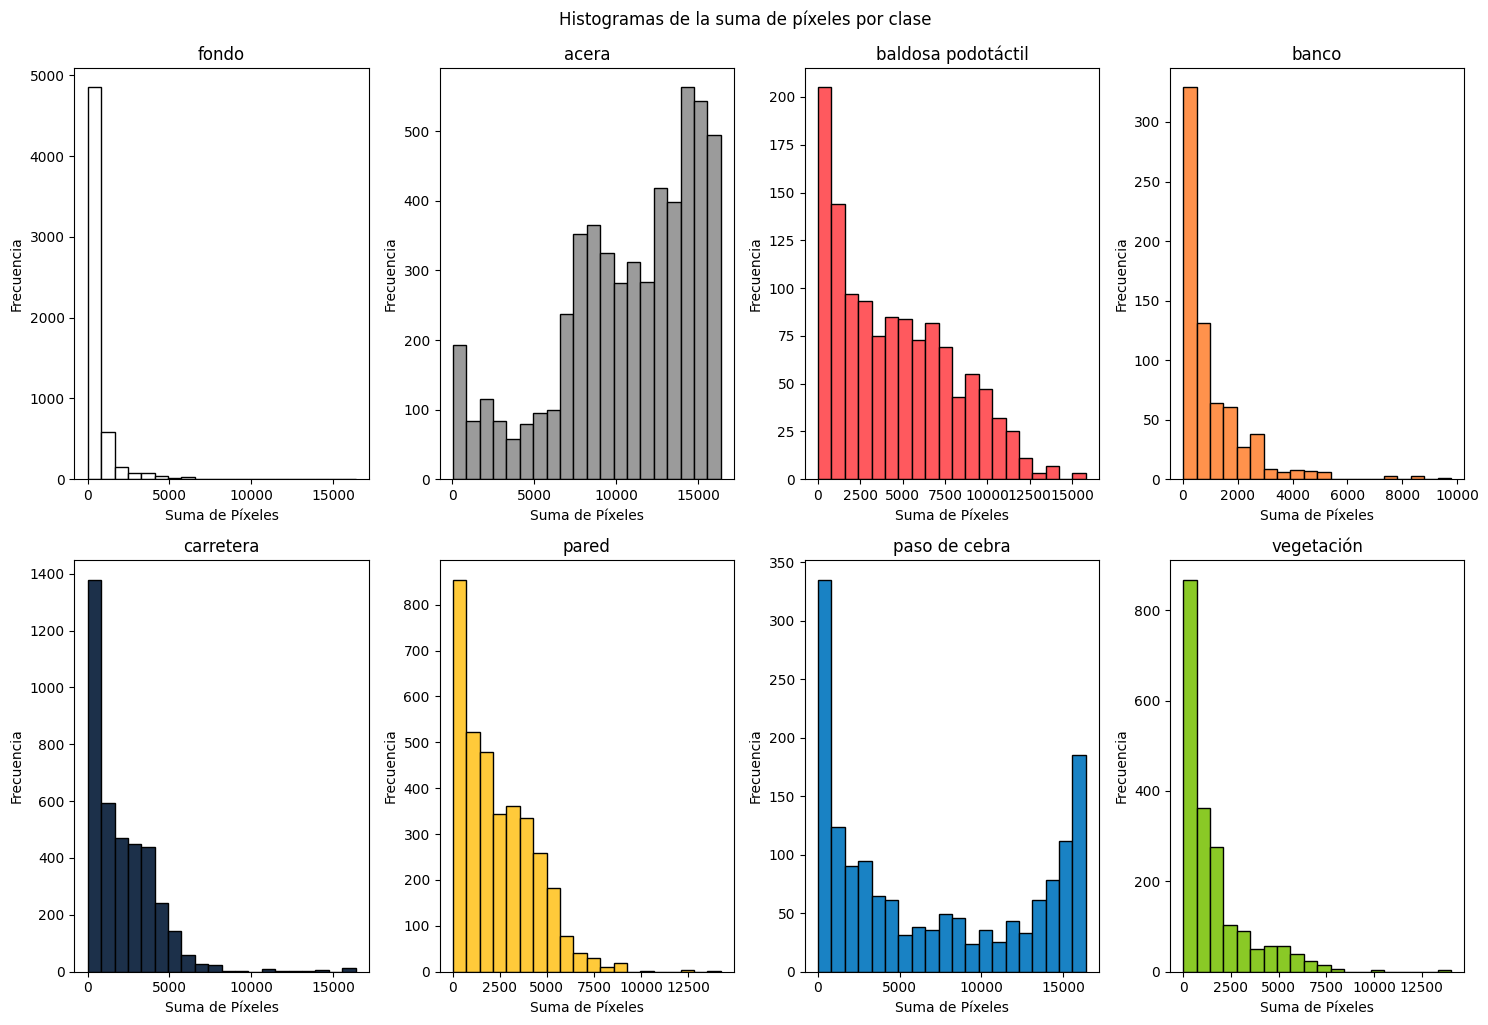

In [65]:
plt.figure(figsize=(15, 10))

for i, (name, color) in enumerate(zip(CLASSES_NAMES, COLOR_DICT)):
    plt.subplot(2, 4, i+1)  # Crear un subgrafico para cada clase
    plt.hist(class_images_counts[i], bins=20, color=color/255.0, edgecolor='black')
    plt.title(name)
    plt.xlabel('Suma de Píxeles')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Histogramas de la suma de píxeles por clase', y=1.02)
plt.show()

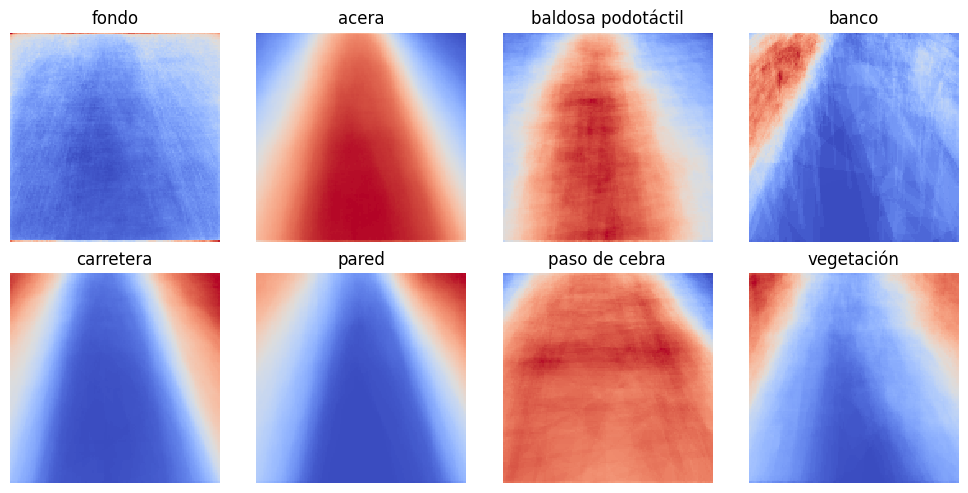

In [80]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()
for i, name in enumerate(CLASSES_NAMES):
    heatmap = np.zeros_like(y[0], dtype=float)
    for mask in y:
        heatmap += (mask == i).astype(float)
    heatmap /= len(y)
    axes[i].imshow(heatmap, cmap='coolwarm', interpolation='nearest')
    axes[i].set_title(name)
    axes[i].axis('off')
plt.tight_layout()
plt.show()